# Follow-up Analysis of IceCube-210922A

- [IceCube AMON/GCN Astrotrack Alert](https://gcn.gsfc.nasa.gov/notices_amon_g_b/135736_30987826.amon)
- [IceCube-210922A GCN Circular](https://gcn.gsfc.nasa.gov/gcn3/30862.gcn3)

In [1]:
import os
from glob import glob
from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from desispec.spectra import stack as specstack
from desispec.coaddition import coadd, coadd_cameras
from desispec.specscore import compute_coadd_scores
from desispec.io import read_spectra, write_spectra

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='small')

## List of TDE Candidates in Tile 23005

TDE candidates from David Moutard's pEW feature matching code.

In [3]:
# List of TDE candidates from 23005 using the finder from David M.
tde_finder_list = (
(39627665015050337, 3),
(39636443059981345, 3),
(39627646950181747, 3),
(39627646950180635, 4),
(39627658975253422, 3),
(39627665002467643, 3),
(39627677040115831, 3),
(39627671021295344, 3),
(39636467110120550, 3),
(39627677048506969, 3),
(39627677040118581, 3),
(39627689094549769, 3),
(39627683075721200, 3),
(39627683071527413, 3),
(39627707201355927, 3),
(39627695142734833, 3),
(39627707188777589, 3),
(39627713232767569, 3),
(39627701165757534, 3),
(39627707201358643, 3),
(39627701165754635, 3),
(39627713228575440, 3),
(39627719285147916, 3),
(39627713241156922, 3),
(39627719276761358, 3),
(39627713249548670, 3),
(39627701190921800, 3),
(39627707222330128, 3),
(39627689140683656, 3),
(39627683088302445, 3),
(39627683092497949, 3),
(39627677073675292, 3),
(39627677069477463, 4),
(39627659008804525, 3),
(39627659000415965, 3),
(39627665023436068, 3))

tde_targids = [x[0] for x in tde_finder_list]

## Access Spectra and Redshifts from Tile 23005

Match TARGETID against the list of TDE candidates and save those spectra for analysis.

In [4]:
tfolder = '/global/cfs/cdirs/desi/users/sjbailey/spectro/redux/icecube-202109a/tiles/pernight/23005/20210923'

In [5]:
coadds = None
redshifts = None
targradec = None
coadd_files = sorted(glob('{}/coadd*.fits'.format(tfolder)))

for coadd_file in coadd_files:
    # Extract spectra and coadd across cameras.
    spectra = read_spectra(coadd_file)
    select = np.in1d(spectra.fibermap['TARGETID'], tde_targids)
    if np.any(select):
        if coadds is None:
            coadds = spectra[select]
            targradec = spectra.fibermap['TARGET_RA', 'TARGET_DEC']
        else:
            coadds = specstack([coadds, spectra[select]])
            targradec = vstack([targradec, spectra.fibermap['TARGET_RA', 'TARGET_DEC']])
            
    # Extract the best-fit redshift information.
    rr_file = coadd_file.replace('coadd', 'redrock')
    zbest = Table.read(rr_file, 'REDSHIFTS')
    select = np.in1d(zbest['TARGETID'], tde_targids)
    if np.any(select):
        if redshifts is None:
            redshifts = zbest[select]
        else:
            redshifts = vstack([redshifts, zbest[select]])

coadds.extra_catalog = redshifts

INFO:spectra.py:282:read_spectra: iotime 0.585 sec to read coadd-0-23005-20210923.fits at 2021-09-29T09:54:28.835213
INFO:spectra.py:282:read_spectra: iotime 0.566 sec to read coadd-1-23005-20210923.fits at 2021-09-29T09:54:29.850381
INFO:spectra.py:282:read_spectra: iotime 0.596 sec to read coadd-2-23005-20210923.fits at 2021-09-29T09:54:30.964510
INFO:spectra.py:282:read_spectra: iotime 0.613 sec to read coadd-3-23005-20210923.fits at 2021-09-29T09:54:32.118405
INFO:spectra.py:282:read_spectra: iotime 0.526 sec to read coadd-4-23005-20210923.fits at 2021-09-29T09:54:33.231263
INFO:spectra.py:282:read_spectra: iotime 0.540 sec to read coadd-5-23005-20210923.fits at 2021-09-29T09:54:34.305789
INFO:spectra.py:282:read_spectra: iotime 0.569 sec to read coadd-6-23005-20210923.fits at 2021-09-29T09:54:35.411587
INFO:spectra.py:282:read_spectra: iotime 0.518 sec to read coadd-7-23005-20210923.fits at 2021-09-29T09:54:36.468104
INFO:spectra.py:282:read_spectra: iotime 0.500 sec to read coadd

### Plot Fibers and IC-210922A

Plot the fiber positions and TDE candidates against the 90% circularized C.I. of the $\nu_\mu$ alert IC210922A.

In [6]:
ic_ra, ic_dec, ic_r90 = 60.7299, -4.1799, 0.65

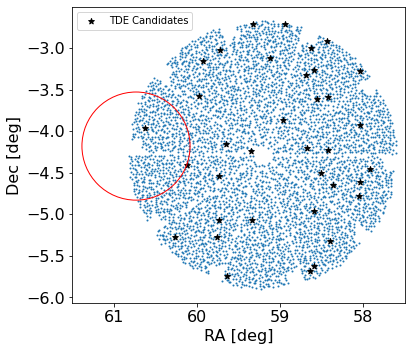

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6,6), tight_layout=True)

ax.scatter(targradec['TARGET_RA'], targradec['TARGET_DEC'], s=1)

c = mpl.patches.Circle((ic_ra, ic_dec), ic_r90, edgecolor='red', facecolor='none')
ax.add_patch(c)

ax.scatter(coadds.fibermap['TARGET_RA'], coadds.fibermap['TARGET_DEC'], marker='*', color='k', label='TDE Candidates')

ax.set(aspect='equal',
       xlabel='RA [deg]',
       xlim=(61.5, 57.5),
       ylabel='Dec [deg]')

ax.legend(fontsize=10);

## Access Legacy Survey Cutouts and Plot Spectra

Plot the spectra and cutout images of observed TDE candidates within some distance from IC-210922A.

In [8]:
import requests

def get_cutout(targetid, ra, dec, size=180, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    """
    img_name = '{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}'.format(ra, dec, size)
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
    
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [9]:
from scipy.ndimage import gaussian_filter1d

mpl.rc('figure', max_open_warning = 0)

In [10]:
# Emission and absorption lines from Prospect tables.
emi_lines = ascii.read('emission_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])
abs_lines = ascii.read('absorption_lines.txt', comment='#', names=['name','longname','lambda','vacuum','major'])

emi_lines_major = emi_lines[emi_lines['major']=='True']
abs_lines_major = abs_lines[abs_lines['major']=='True']

### Containment Cut

Here we make a containment cut on the TDE candidates to see if the fall within (some multiple of) the 90% C.I. of IC-210922A.

In [11]:
tde_cand_coords = SkyCoord(ra=coadds.fibermap['TARGET_RA'], dec=coadds.fibermap['TARGET_DEC'], unit='degree')
ic_coord = SkyCoord(ra=[ic_ra], dec=[ic_dec], unit='degree')

idx, sep2d, sep3d = match_coordinates_sky(tde_cand_coords, ic_coord)
is_contained = sep2d < 2*ic_r90*u.degree

np.sum(is_contained)

6

### Loop through Contained Candidates and Plot Spectra

148.40155595541 0
213.08721327781677 0
216.89260843396187 0
1762.9967432618141 0
194.01497173309326 0
67.25113597512245 0


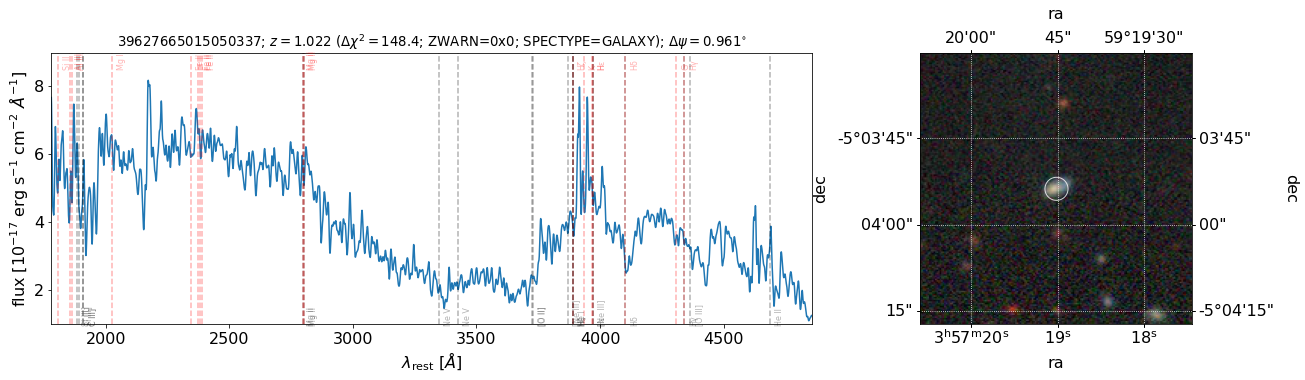

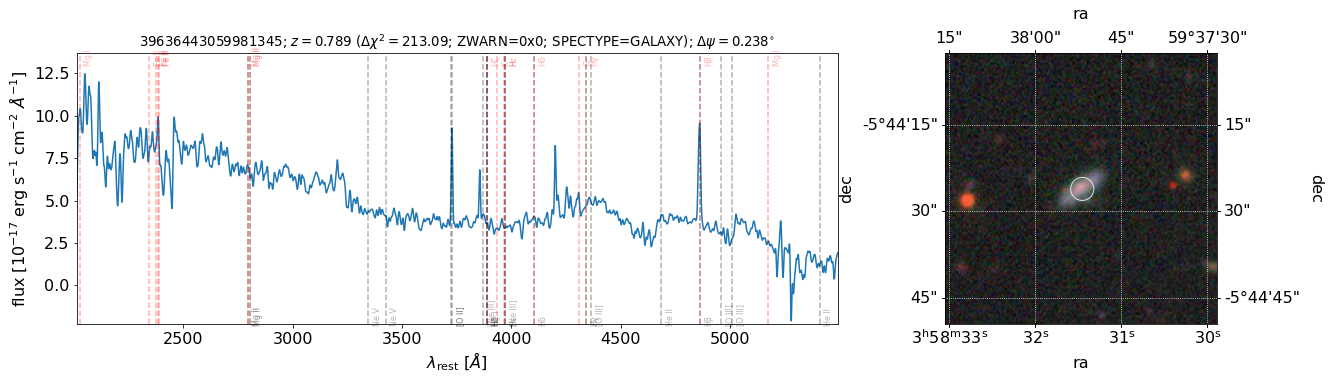

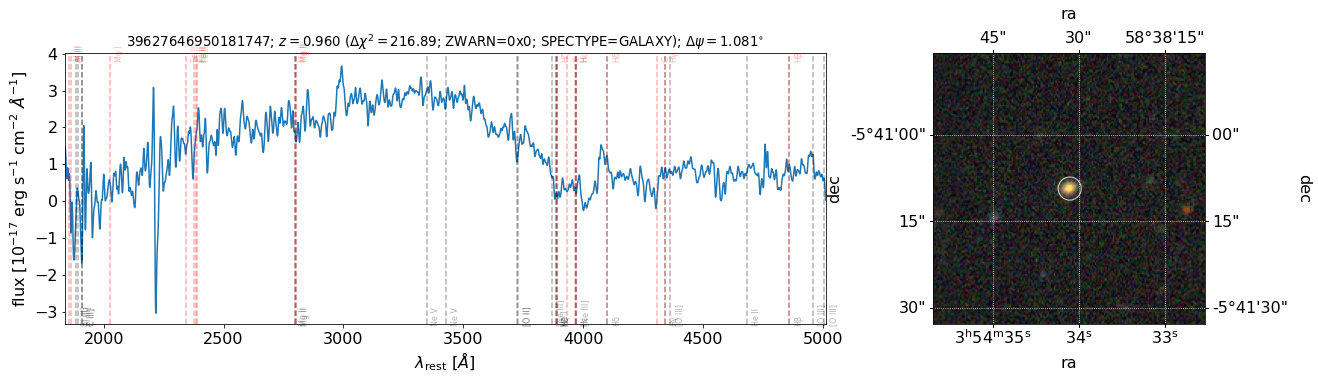

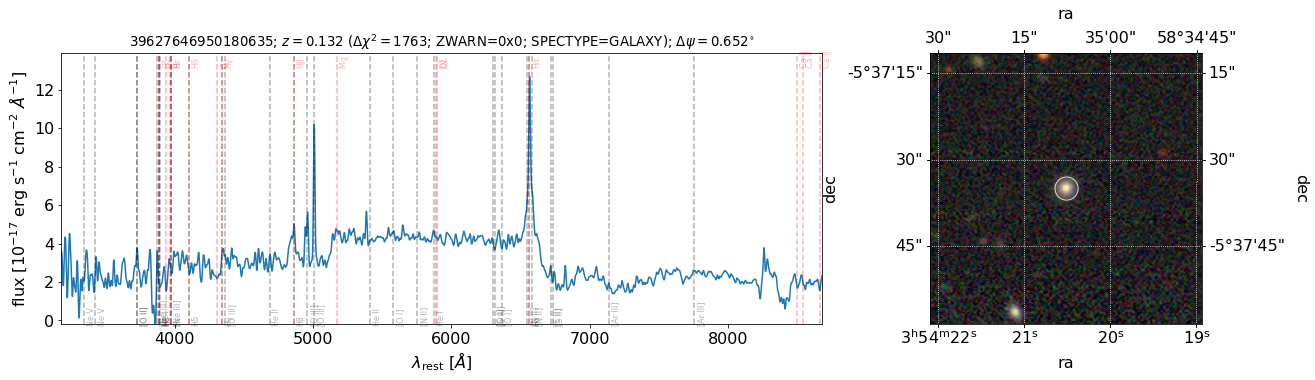

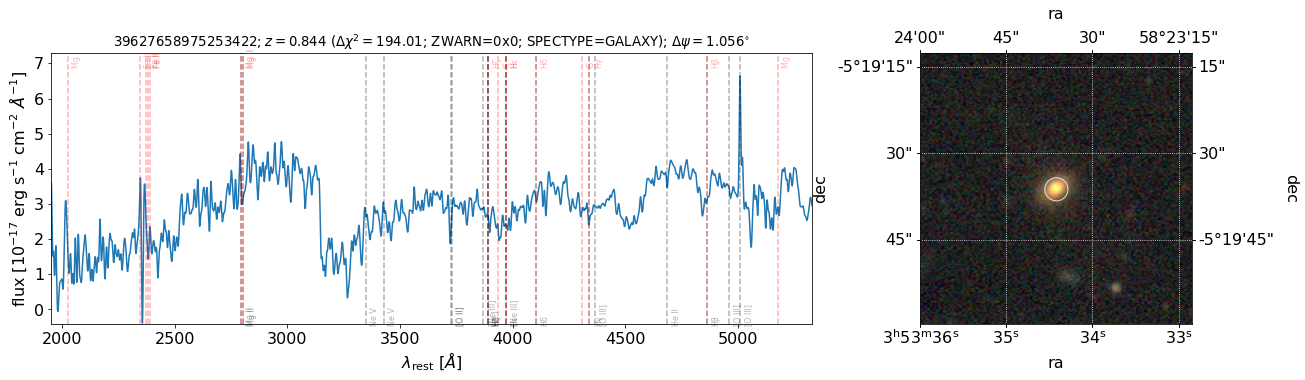

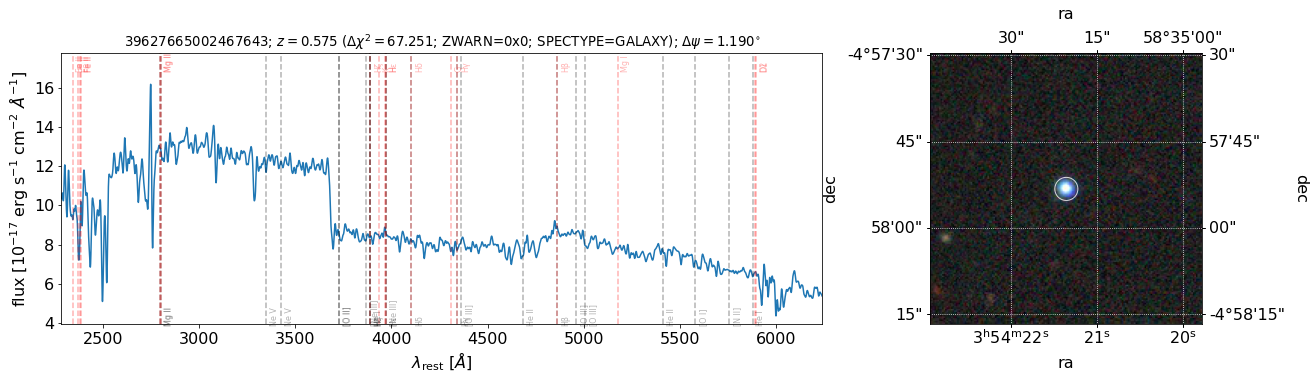

In [12]:
for i in range(coadds[is_contained].num_spectra()):
    
    fig = plt.figure(figsize=(20.5,5))
    gs = mpl.gridspec.GridSpec(1,2, width_ratios=[3,1.1])
    ax = fig.add_subplot(gs[0])
    
    coadded_flux = coadd_cameras(coadds[i])
    
    zbest = coadds.extra_catalog[i]
    z = zbest['Z']
    dchi2 = zbest['DELTACHI2']
    zwarn = zbest['ZWARN']
    sptype = zbest['SPECTYPE']
    print(dchi2, zwarn)

    smoothed = gaussian_filter1d(coadded_flux.flux['brz'][0], 7)
    fmin, fmax = 1e99, -1e99
    fmin = np.minimum(fmin, np.min(smoothed))
    fmin = 0.9*fmin if fmin > 0 else 1.1*fmin
    fmax = 1.1*np.maximum(fmax, np.max(smoothed))
    
#     fmin, fmax = -2, 8
    restwave = coadded_flux.wave['brz']/(1+z)
    ax.plot(restwave, smoothed)
    
    for eline in emi_lines:
        wl = eline['lambda']#*(1 + z)
        if wl > restwave[0] and wl < restwave[-1]:
            ax.axvline(wl, ls='--', color='k', alpha=0.3)
            ax.text(wl+20, fmin, eline['name'], fontsize=8, rotation=90, alpha=0.3)

    for aline in abs_lines:
        wl = aline['lambda']#*(1 + z)
        if wl > restwave[0] and wl < restwave[-1]:
            ax.axvline(wl, ls='--', color='r', alpha=0.3)
            ax.text(wl+20, 0.95*fmax, aline['name'], color='r', fontsize=8, rotation=90, alpha=0.3)

    ax.set(xlabel=r'$\lambda_{\mathrm{rest}}$ [$\AA$]',
           xlim=(restwave[0], restwave[-1]),
           ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
           ylim=(fmin, fmax),
           title=r'{}; $z={:.3f}$ ($\Delta\chi^2={:.5g}$; ZWARN=0x{:x}; SPECTYPE={:s}); $\Delta\psi={:.3f}^{{\circ}}$'.format(
               coadds.fibermap[i]['TARGETID'], z, dchi2, zwarn, sptype, sep2d[is_contained][i].to_value('degree')),
          )
    
    # Plot the image cutout.
    obj = coadds.fibermap[i]
    obj_exp = coadds.exp_fibermap[i]
    img_file, wcs = get_cutout(obj['TARGETID'], obj['TARGET_RA'], obj['TARGET_DEC'])
    img = mpl.image.imread(img_file)

    ax = fig.add_subplot(gs[1], projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted')
    
    ra = obj['MEAN_FIBER_RA']
    dec = obj['MEAN_FIBER_DEC']
    r = SphericalCircle((ra * u.deg, dec * u.deg), 2 * u.arcsec,
                 edgecolor='white', facecolor='none', alpha=0.8,
                 transform=ax.get_transform('icrs'))
    ax.add_patch(r)

    ax.set(#aspect='equal',
       xlabel='ra',
       ylabel='dec')
    
    fig.savefig('spec_cutout_{}_{}_{:06d}_{:06d}.png'.format(obj['TARGETID'], obj_exp['NIGHT'], obj['TILEID'], obj_exp['EXPID']), dpi=100)

In [13]:
coadds.fibermap[coadds.fibermap['TARGETID'] == 39627646950180635]

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32
39627646950180635,1,398,1398,540,0,58.585494111310744,-5.626392708073142,0.0,0.0,2015.5,5400.0,1152921504606846976,1,TGT,157.46338,-338.45126,2100,0.8520013950964213,516,9010,0586m057,297519,1819,DEV,0.11135308,7.3322616,14.31727,23.916832,22.554466,18.76169,446.7492,132.83276,46.607693,1.9381833,0.44868997,3.5530512,6.9378314,11.589566,3.5530512,6.9378314,11.589566,0,4.0,0.4987148,0.0048949635,-0.023908969,3245246536892051456,G2,20.967701,20.70049,19.308798,0.0,S,2100,2,1152921504606846976,131074,0,0,58.585494111310744,-5.626392708073142,23005,2,2222.6387,1,1,-0.009,0.009,0.001,0.001,58.58545876532089,0.0,-5.626395563035476,0.0,0.7671113,157.515,-338.525


## Compute Scores of all Spectra in the 90% C.I.

In [28]:
coadds = None
targradec = None
coadd_files = sorted(glob('{}/coadd*.fits'.format(tfolder)))

ic_coord = SkyCoord(ra=[ic_ra], dec=[ic_dec], unit='degree')

for coadd_file in coadd_files:
    # Extract spectra.
    spectra = read_spectra(coadd_file)
    
    # Extract redshifts.
    rr_file = coadd_file.replace('coadd', 'redrock')
    zbest = Table.read(rr_file, 'REDSHIFTS')
    
    # Select galaxies and QSOs (according to redrock).
    idx = np.where(np.in1d(spectra.fibermap['TARGETID'], zbest['TARGETID']))[0]
    is_gal_qso = zbest['SPECTYPE'][idx] == 'GALAXY' #!= 'STAR'
    
    # Select objects that are targets.
    is_tgt = spectra.fibermap['OBJTYPE'] == 'TGT'
    is_good = spectra.fibermap['COADD_FIBERSTATUS'] == 0
    
    # Select fibers within the 90% C.I.
    sp_coords = SkyCoord(ra=spectra.fibermap['TARGET_RA'], dec=spectra.fibermap['TARGET_DEC'], unit='deg')
    idx, sep2d, sep3d = match_coordinates_sky(sp_coords, ic_coord)
    is_contained = sep2d <= ic_r90*u.degree
    
    select = is_contained & is_tgt & is_good & is_gal_qso
    
    if np.any(select):
        if coadds is None:
            coadds = spectra[select]
        else:
            coadds = specstack([coadds, spectra[select]])

print(coadds.num_spectra())

INFO:spectra.py:282:read_spectra: iotime 0.515 sec to read coadd-0-23005-20210923.fits at 2021-09-29T10:04:27.405623
INFO:spectra.py:282:read_spectra: iotime 0.484 sec to read coadd-1-23005-20210923.fits at 2021-09-29T10:04:28.563302
INFO:spectra.py:282:read_spectra: iotime 0.527 sec to read coadd-2-23005-20210923.fits at 2021-09-29T10:04:29.580710
INFO:spectra.py:282:read_spectra: iotime 0.452 sec to read coadd-3-23005-20210923.fits at 2021-09-29T10:04:30.544483
INFO:spectra.py:282:read_spectra: iotime 0.601 sec to read coadd-4-23005-20210923.fits at 2021-09-29T10:04:31.617727
INFO:spectra.py:282:read_spectra: iotime 0.472 sec to read coadd-5-23005-20210923.fits at 2021-09-29T10:04:32.554249
INFO:spectra.py:282:read_spectra: iotime 0.470 sec to read coadd-6-23005-20210923.fits at 2021-09-29T10:04:33.592780
INFO:spectra.py:282:read_spectra: iotime 0.541 sec to read coadd-7-23005-20210923.fits at 2021-09-29T10:04:34.579234
INFO:spectra.py:282:read_spectra: iotime 0.576 sec to read coadd

In [29]:
coadds.scores

TARGETID,INTEG_COADD_FLUX_B,MEDIAN_COADD_FLUX_B,MEDIAN_COADD_SNR_B,INTEG_COADD_FLUX_R,MEDIAN_COADD_FLUX_R,MEDIAN_COADD_SNR_R,INTEG_COADD_FLUX_Z,MEDIAN_COADD_FLUX_Z,MEDIAN_COADD_SNR_Z,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
39627683100888449,929.0175,0.54768634,0.29717308,3692.8088,2.0266128,2.653814,1915.1414,0.89853704,1.5071099,22.769445,0.012357103,4.440528,10.804454,68.5681,43.333755,0.3364236,0.12937538,1128.77,2.6799617,220.18045,0.0060600555,257.916,2149.8,0.81038964,3.7823114,3.9697093e-06,16.43738,7.7443593e-07,0.0,757.38983,7.5686617e-06,3.4601276,7.446569,1151.5394,19.129698,224.62097,10.8105135,1083.8739,2193.1338,4.6069407,11.358255
39627683100889256,2853.728,1.5923727,0.9621162,3196.5417,1.7308934,2.3070424,3377.7996,1.4598527,2.9377866,25.529133,0.013610284,4.9766097,12.062759,75.38759,48.51887,0.37091202,0.14146478,1217.6213,2.9024515,237.4627,0.0064826384,278.0716,2318.3833,0.8763221,4.092428,4.2427037e-06,17.644255,8.2740985e-07,0.0,816.48584,8.081526e-06,3.7218683,8.004625,1243.1505,20.560316,242.43932,12.0692425,1169.9451,2366.902,4.9691024,12.238518
39627683100885501,1698.3773,1.0667905,0.59952617,7245.966,3.986922,5.6277637,6431.2964,2.8870912,6.262373,25.800358,0.013971191,5.0169277,12.639235,76.770775,49.270935,0.38262838,0.14343603,1249.0626,2.9759343,242.91267,0.006578919,284.59515,2386.1614,0.9024754,4.187954,4.1599724e-06,17.627163,8.092113e-07,0.0,812.5544,7.960992e-06,3.7292204,7.9670334,1274.863,20.61707,247.9296,12.645813,1173.9203,2435.4324,5.014324,12.298424
39627683100889069,4002.994,2.1791778,1.2870743,-346.29773,-0.20719768,-0.26152253,-16.257156,0.01305542,0.01643164,25.807161,0.013855232,5.0336504,12.332519,76.57153,48.934364,0.3773683,0.14357273,1185.7522,2.8159518,231.45032,0.0062640323,269.85135,2255.8208,0.849319,3.9721,4.0726063e-06,17.49978,7.949568e-07,0.0,802.154,7.7522645e-06,3.669747,7.8870645,1211.5593,20.329588,236.48396,12.338782,1148.5769,2304.7551,4.8964343,12.002737
39627683109274661,3406.6794,2.0436246,1.1052295,9454.023,5.177578,6.7210994,12090.911,5.5051866,11.654932,26.86482,0.014666771,5.2750854,13.115126,81.39753,50.464626,0.39579314,0.14977823,1230.5409,2.9125545,241.72844,0.0064088474,283.9817,2315.884,0.87339497,4.1333876,4.0775612e-06,17.12375,8.0109083e-07,0.0,806.0798,7.681244e-06,3.5852818,7.831005,1257.4058,20.050972,247.00352,13.121534,1171.459,2366.3486,4.8544703,12.114171
39627683105083198,7057.183,4.0271635,2.2664826,14989.173,8.29617,11.1890545,16008.56,7.2917457,14.755768,25.604033,0.013907923,5.023096,12.385213,77.29655,48.242794,0.3759127,0.14243613,1205.0355,2.876397,236.45113,0.006368395,278.24576,2271.8528,0.85950637,4.058178,3.973056e-06,16.5509,7.797399e-07,0.0,782.6347,7.5016424e-06,3.477693,7.5891333,1230.6395,19.441204,241.47423,12.391582,1138.177,2320.0955,4.713112,11.789747
39627683105086612,1719.774,1.1214081,0.61288285,9178.368,5.057585,6.984027,8757.083,4.033978,8.429706,25.961258,0.014045203,5.093735,12.505246,78.10078,48.916367,0.37963173,0.14370084,1225.2023,2.916915,240.42068,0.0064302147,283.2912,2309.311,0.87534297,4.1354356,4.0191553e-06,17.013233,7.887144e-07,0.0,799.68146,7.5815706e-06,3.56706,7.7671356,1251.1636,19.944193,245.51442,12.511677,1161.0735,2358.2273,4.822035,12.046272
39627683105084001,9617.832,5.424904,3

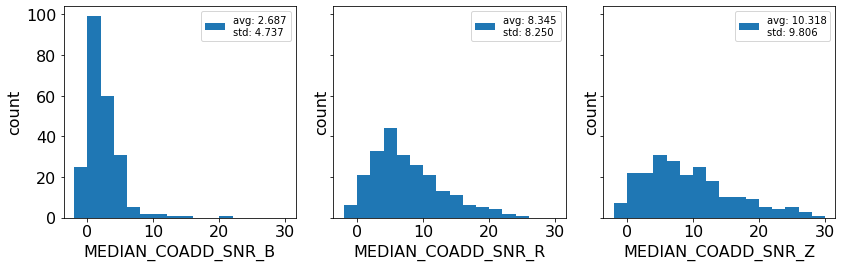

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(12,4), tight_layout=True, sharex=True, sharey=True)

for band, ax in zip('brz', axes):
    snr = 'MEDIAN_COADD_SNR_{}'.format(band.upper())
    ax.hist(coadds.scores[snr], bins=np.arange(-2,31,2),
        label='avg: {:.3f}\nstd: {:.3f}'.format(
        np.average(coadds.scores[snr]),
        np.std(coadds.scores[snr])))
    ax.set(xlabel=snr, ylabel='count')
    ax.legend(loc='upper right', fontsize=10)